## Import Modules

In [5]:
import pandas as pd
import numpy as np
import time
import os
import copy
import json

# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms

# augmentation
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the Dataset

In [6]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"

train = pd.read_csv(BASE_DIR+'train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [7]:
# loading mapping for target label
with open(BASE_DIR+'label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}
mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [8]:
train['label_names'] = train['label'].map(mapping)
train.head()

image_id  label                          label_names
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

## Exploratory Data Analysis

In [9]:
def plot_images(class_id, label, total_images=6):
    # get image ids corresponding to the target class id
    plot_list = train[train['label']==class_id].sample(total_images)['image_id'].tolist()
    
    labels = [label for i in range(total_images)]
    # dynamically set size for subplot
    size = int(np.sqrt(total_images))
    if size*size < total_images:
        size += 1
    
    # set figure size
    plt.figure(figsize=(15,15))
    
    # plot the image in subplot
    for index, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, index+1)
        image = Image.open(str(BASE_DIR+'train_images/'+image_id))
        plt.imshow(image)
        plt.title(label, fontsize=14)
        plt.axis('off')
        
    plt.show()

In [10]:
plot_images(0, mapping[0], 6)

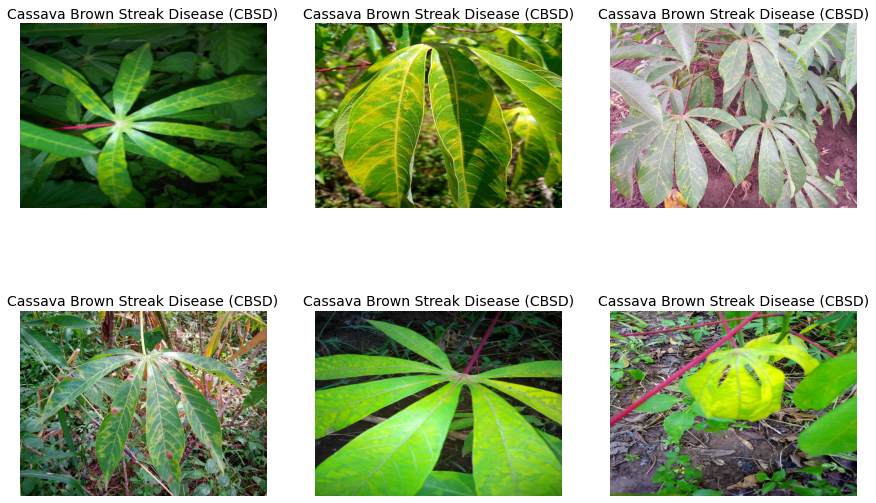

In [11]:
plot_images(1, mapping[1], 6)

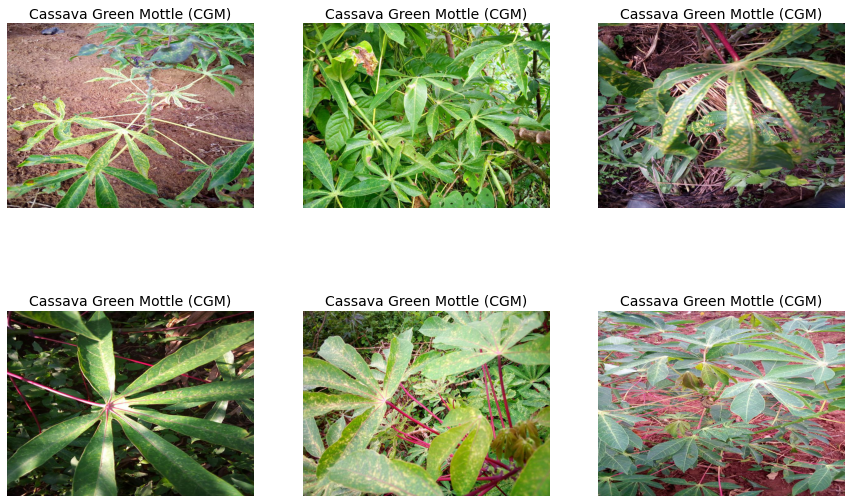

In [12]:
plot_images(2, mapping[2], 6)

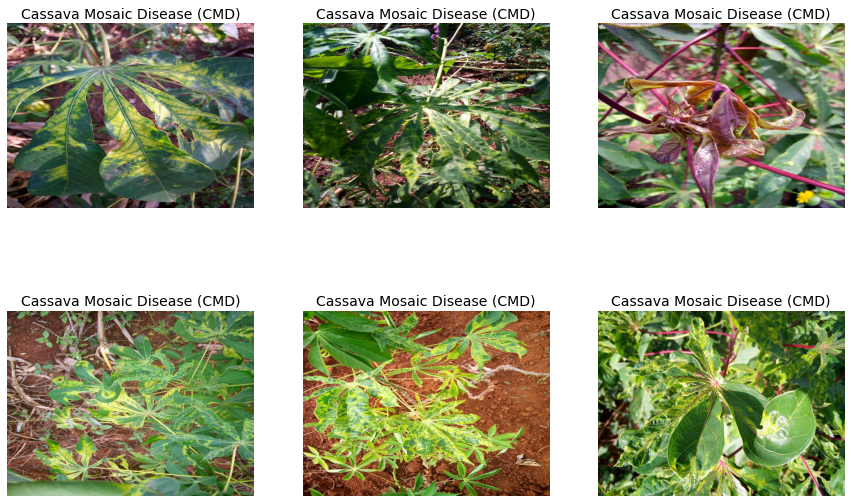

In [13]:
plot_images(3, mapping[3], 6)

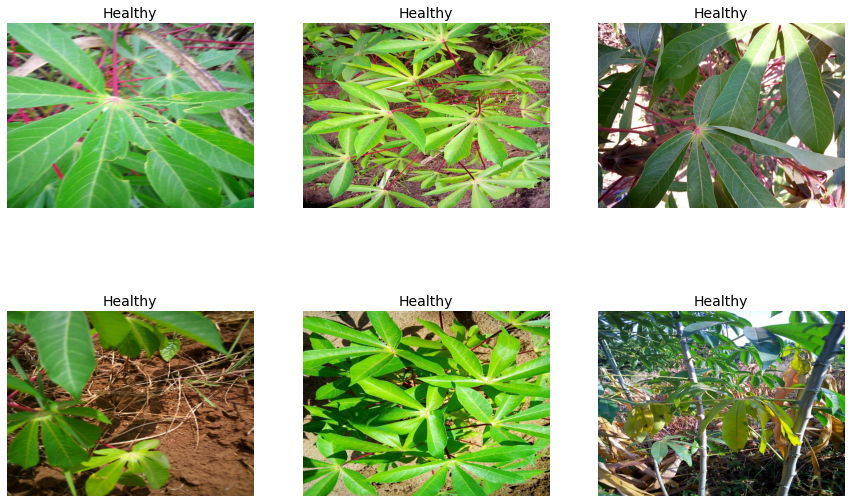

In [14]:
plot_images(4, mapping[4], 6)

In [15]:
# class distribution
sns.countplot(train['label_names'])
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Cassava Bacterial Blight (CBB)'),
  Text(1, 0, 'Cassava Mosaic Disease (CMD)'),
  Text(2, 0, 'Cassava Brown Streak Disease (CBSD)'),
  Text(3, 0, 'Cassava Green Mottle (CGM)'),
  Text(4, 0, 'Healthy')])

## Configuration and Utility Functions

In [16]:
DIM = (256, 256)
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
NUM_WORKERS = 24
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
SEED = 1

DEVICE = 'cuda'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## Augmentations

In [17]:
def get_test_transforms(value = 'val'):
    if value == 'train':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])
    elif value == 'val':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])

## Dataset Loader Class

In [18]:
class CassavaDataset(Dataset):
    def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='train_images'):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.dim = dimension
        self.augmentations = augmentations
        self.folder = folder
    
    # returns the length
    def __len__(self):
        return len(self.image_ids)
    
    # return the image and label for that index
    def __getitem__(self, idx):
        img = Image.open(os.path.join(BASE_DIR, self.folder, self.image_ids[idx]))
        
        if self.dim:
            img = img.resize(self.dim)
        
        # convert to numpy array
        img = np.array(img)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

## Train Test Split

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)

In [20]:
from torch.utils.data import WeightedRandomSampler
def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)
    print('Unique Labels', label_unique)
    weights = [sum(counts) / c for c in counts]
    sample_weights = [weights[w] for w in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [21]:
train_sampler = sampler_(y_train)

Unique Labels [0 1 2 3 4]


In [22]:
# create dataloaders for training antrain_test_splitidation
train_dataset = CassavaDataset(
    image_ids=x_train.values,
    labels=y_train.values,
    augmentations=get_test_transforms('train'),
    dimension=DIM
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    sampler=train_sampler
)

val_dataset = CassavaDataset(
    image_ids=x_test.values,
    labels=y_test.values,
    augmentations=get_test_transforms('val'),
    dimension=DIM
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

loaders = {'train': train_loader, 'val': val_loader}

In [23]:
# to check whether dataset is working or not
# fetch the data based on index
val_dataset[0]

(tensor([[[ 0.5022,  0.8618,  0.4508,  ..., -0.9192, -1.0219, -0.4054],
          [-0.0458,  0.4337,  0.9303,  ..., -0.7650, -0.6281, -0.6452],
          [ 0.3652,  0.0398,  0.4337,  ..., -1.4329, -1.1760, -1.0562],
          ...,
          [-0.0629, -0.2856, -0.2513,  ..., -1.3987, -1.5185, -1.7069],
          [-0.3712, -0.3541, -0.1999,  ..., -1.4329, -1.5357, -1.6213],
          [ 0.0056,  0.1254, -0.1657,  ..., -1.3987, -1.5185, -1.6384]],
 
         [[ 0.5903,  0.9405,  0.5553,  ..., -1.4055, -1.6506, -0.8803],
          [-0.1275,  0.4853,  1.1856,  ..., -1.0903, -1.0728, -0.9853],
          [-0.2150, -0.4076,  0.2752,  ..., -1.5630, -1.4755, -1.2654],
          ...,
          [ 0.8004,  0.4678,  0.3978,  ..., -0.6176, -0.7227, -0.9153],
          [ 0.3627,  0.3452,  0.4678,  ..., -0.6702, -0.7577, -0.8277],
          [ 0.5903,  0.7304,  0.4853,  ..., -0.6527, -0.7402, -0.8452]],
 
         [[-0.1487,  0.3568, -0.0092,  ..., -1.4210, -1.6302, -1.3164],
          [-0.7413, -0.0267,

## Use Pretrained Model (Transfer Learning)

In [24]:
def getModel():
    net = models.resnet152(pretrained=True)
    
    # if you want to train the whole network, comment this code
    # freeze all the layers in the network
    for param in net.parameters():
        param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    # create last few layers
    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, NUM_CLASSES),
        nn.LogSoftmax(dim=1)
    )
    
    # use gpu if any
    net = net.cuda() if DEVICE else net
    return net

In [25]:
model = getModel()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [26]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [27]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)
step_size = 4*len(train_loader)
clr = cyclical_lr(step_size, min_lr=3e-4, max_lr=3e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [28]:
# print(model)

In [29]:
# freeze (or) unfreeze all the layers
unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze

In [30]:
# find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')

58,669,637 total parameters
58,669,637 training parameters


## Steps for Training and Validation

In [31]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, scheduler=scheduler):
    # set starting time
    start_time = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*15)
        
        # each epoch have training and validation phase
        for phase in ['train', 'val']:
            # set mode for model
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            fin_out = []
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to corresponding hardware
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                # reset (or) zero the parameter gradients
                optimizer.zero_grad()
                
                # training (or) validation process
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # back propagation in the network
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # calculate loss and accuarcy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # print loss and acc for training & validation
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # update the best weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
        print()
    end_time = time.time() - start_time
    
    print('Training completes in {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [32]:
# train the model
model, accuracy = train_model(model=model, dataloaders=loaders, criterion=criterion, optimizer=optimizer, num_epochs=5, scheduler=scheduler)

Epoch 0/4
---------------
train Loss: 1.2207 Acc: 0.5154
val Loss: 0.6961 Acc: 0.7460

Epoch 1/4
---------------
train Loss: 0.7270 Acc: 0.7339
val Loss: 0.6009 Acc: 0.7867

Epoch 2/4
---------------
train Loss: 0.6226 Acc: 0.7768
val Loss: 0.5246 Acc: 0.8185

Epoch 3/4
---------------
train Loss: 0.5751 Acc: 0.7982
val Loss: 0.6119 Acc: 0.7964

Epoch 4/4
---------------
train Loss: 0.5003 Acc: 0.8212
val Loss: 0.4741 Acc: 0.8452

Training completes in 30m 54s
Best Val Acc: 0.8452


In [ ]:
# save the model and model weights
torch.save(model, '/kaggle/working/best_model.h5')
torch.save(model.state_dict(), '/kaggle/working/best_model_weights')

In [ ]:
# freeze (or) unfreeze all the layers
unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze

In [ ]:
# # unfreeze seleected layers
# layers = list(range(5,7))
# i = 0
# for layer in model.children():
#     if i in layers:
#         for param in layer.parameters():
#             param.requires_grad = True
#     i += 1

In [ ]:
# find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')

In [ ]:
# # gives the number of layers
# for i,layer in enumerate(model.children()):
#     print(i)

## Testing the Model

In [33]:
# empty the cache from cuda device
torch.cuda.empty_cache()

In [34]:
def predict(model, dataloader, device):
    # set mode to eval
    model.eval()
    fin_out = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())
            
    return np.concatenate(fin_out)

In [35]:
# steps for model prediction
device = torch.device('cuda') # if you don't have gpu, set it as cpu
model.to(device)
pred = predict(model, val_loader, device)
pred = pred.argmax(axis=1)

In [36]:
y_test.values[:5]

array([3, 1, 3, 3, 2])

In [37]:
pred[:5]

array([3, 4, 3, 3, 2])